# <span style='color:red'>Problem Set 3: More Factors</span>

## Instructions:

- **Make a copy of this notebook somewhere under the root-folder *except* for the shared-folder**
  - In JHub we have read-only access to the material under /shared
  - Everything else is associated with your Dartmouth ID and so only you can see them and they are permanent
- Enter the answers on this notebook
  - In most cases, you just need to execute the code and leave the output as it is
- All of the code needed here can be found in Topic1_PythonBasics 
- In some cases, I ask you to explain something. In the cases, there is an extra markup cell (**ANSWER:**) that you can fill out 
- When you are done, select "Print..." from the File-menu and create an **HTML** version of the notebook
  - Submit this notebook through canvas
  - Please don't submit it as a notebook (.ipynb) file

# Problem 1: Fama and French's Investment factor

In Topic #4, we replicated Fama and French's value and size factors. We constructed this factor by:

1. sorting all stocks into six portfolios by size and book-to-market  
2. computing value-weighted returns on these portfolios (that is, the amount you invested in each stock is proportional to its market capitalization)
3. computing the difference in average returns between the two value ("high") and growth ("low") portfolios

From the dataset we created, it is equally easy to replicate Fama and French's investment factor. They call this factor CMA for "Conservative minus Aggressive." This factor is constructed almost the same way as HML:

1. sort all stocks into six portfolios by size and **investment**  
2. compute value-weighted returns on these portfolios (that is, the amount you invested in each stock is proportional to its market capitalization)
3. compute the difference in average returns between the two conservative ("low") and aggressive ("high") portfolios

So, we only need to swap **beme** for something else and, at the end take the difference low-minus-high instead of high-minus-low.

In Topic #4, we define **beme** like this:

```
cs_crsp['beme'] = cs_crsp['be'] / cs_crsp['me']
negative_be = cs_crsp['be'] < 0
cs_crsp.loc[negative_be, 'beme'] = np.nan
```

Replace these lines with this:

```
cs_crsp['asset_growth'] = cs_crsp['at'] / cs_crsp.groupby(level='permno')['at'].shift(12)
bad_data = (cs_crsp['at'] <= 0) | (cs_crsp.groupby(level='permno')['at'].shift(12) <= 0) 
cs_crsp.loc[bad_data, 'asset_growth'] = np.nan
```

The ```bad_data``` part is about taking out observations where we have 0 or negative total assets -- which is probably a data error.

If you then replace **beme** with **asset_growth** in the code, it'll create the six portfolios for you. You can then define the ```cma``` as a similar difference in portfolio returns. 

### a) What is this factor's Sharpe ratio from the beginning of the data until 2007-06?

In [1]:
import pandas as pd
import numpy as np

def portfolio_sort(df=None, col=None, percentiles=None, id_col=None, annual=True):
    sortvar = df.loc[df['exchcd']==1, col]
    
    df[id_col] = np.nan  
    group_id = 1
    grp = sortvar.dropna().groupby(level='date')
    
    for pct in percentiles:
        breakpoint = grp.apply(lambda x: np.percentile(x, pct))
        breakpoint.name = 'breakpoint'
        df_merged = df.merge(breakpoint, left_on='date', right_index=True, how='left')
        assigned = df_merged[id_col].isnull() & (df_merged[col] <= df_merged['breakpoint'])         
        df.loc[assigned[assigned].index, id_col] = group_id
        group_id += 1
    
    # assign firms to to the right from the last breakpoint into a group 
    assigned = df_merged[id_col].isnull() & (df_merged[col] > df_merged['breakpoint']) 
    df.loc[assigned[assigned].index, id_col] = group_id
    
    if annual:
        nonJune = df.index.get_level_values(level='date').month != 6
        df.loc[nonJune, id_col] = np.nan
        df[id_col] = df.groupby(level='permno')[id_col].ffill(limit=11)
    
    return df


def compute_portfolio_returns(df=None, sort_groups=None):
    
    display(df.shape)

    df['retnm'] = df['ret'].groupby(level='permno').shift(-1)
    df['me_x_retnm'] = df['me'] * df['retnm']

    # require me, sort variables, and return next month
    ok = df['me'].notnull()
    for required_var in ['retnm'] + sort_variables:
        ok = ok & df[required_var].notnull()
    df = df[ok]

    display(df.shape)

    sums = df.reset_index().groupby(by=['date'] + sort_groups)[['me', 'me_x_retnm']].sum()
    portfolio_returns = sums['me_x_retnm'] / sums['me']
    portfolio_returns = portfolio_returns.unstack(level=sort_groups)
    
    # because we used return as of NEXT MONTH, undo the timing so that the date in the index corresponds to the return realization
    portfolio_returns = portfolio_returns.shift(1)
    
    return portfolio_returns


def analyze_returns(r=None, name=None, start_date='1964-01', end_date='2007-06'):
    r = r.loc[start_date:end_date]
    ir = np.sqrt(12) * r.mean() / r.std()
    print(f'Start: {start_date}, End: {end_date}')
    print(f'Sharpe ratio: {ir:.2f}')
    r.cumsum().plot(title=f'Analysis of a strategy: "{name}"', figsize=(12,8))

(816812, 10)

(676064, 12)

Start: 1964-01, End: 2024-06
Sharpe ratio: 0.42


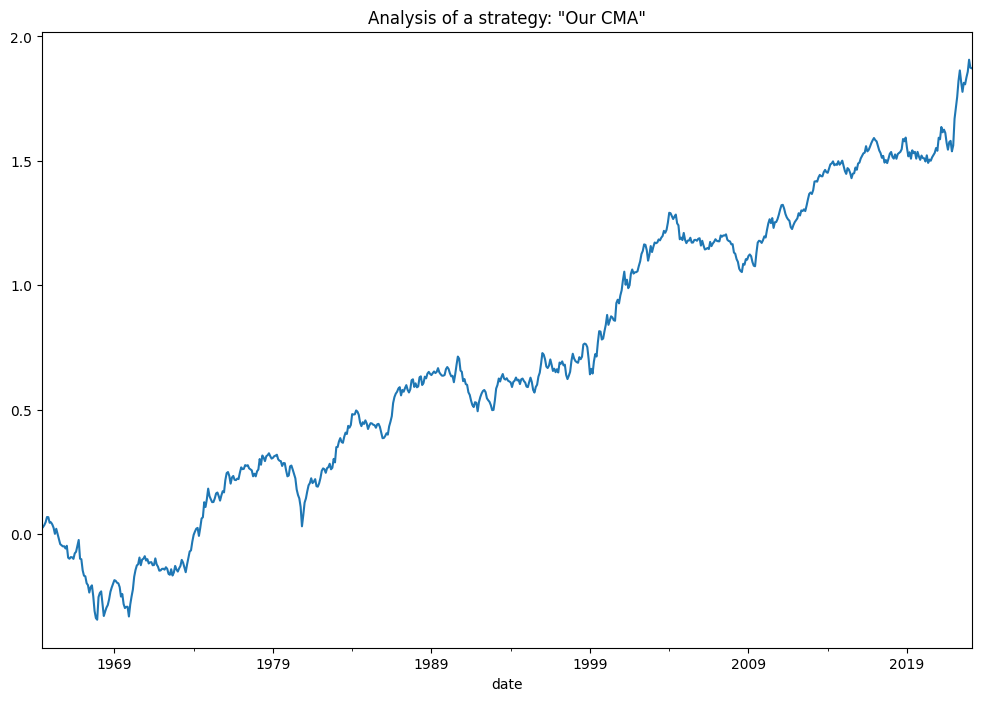

In [2]:
# start from the original data (we will modify it)
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

# construct the asset growth variable
cs_crsp['asset_growth'] = cs_crsp['at'] / cs_crsp.groupby(level='permno')['at'].shift(12)
bad_data = (cs_crsp['at'] <= 0) | (cs_crsp.groupby(level='permno')['at'].shift(12) <= 0) 
cs_crsp.loc[bad_data, 'asset_growth'] = np.nan

sort_variables = ['me', 'asset_growth']
percentiles = {'me': [50],
              'asset_growth': [30, 70]}

for sortvar in sort_variables:
    cs_crsp = portfolio_sort(df=cs_crsp, col=sortvar, percentiles=percentiles[sortvar], id_col=sortvar + '_group', annual=True)
    
sort_groups = [sortvar + '_group' for sortvar in sort_variables]

portfolio_returns = compute_portfolio_returns(cs_crsp, sort_groups=sort_groups)

cma = portfolio_returns.loc[:,[(1,1), (2,1)]].mean(axis=1) - portfolio_returns.loc[:,[(1,3), (2,3)]].mean(axis=1)
cma.name = 'cma'

analyze_returns(cma, 'Our CMA', end_date='2024-06')

### b) What is this factor's correlation with Fama and French's CMA factor?

(We want to check whether our replication gets close.)

In [3]:
ff_data = pd.read_pickle('/home/jovyan/data/ff_data.pkl')

merged_data = pd.concat([cma, ff_data], axis=1).dropna()
merged_data[['cma', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].corr().round(2)

,cma,Mkt-RF,SMB,HML,RMW,CMA
cma,1.00,-0.21,-0.05,0.47,-0.23,0.74
Mkt-RF,-0.21,1.00,0.28,-0.21,-0.18,-0.37
SMB,-0.05,0.28,1.00,-0.03,-0.35,-0.10
HML,0.47,-0.21,-0.03,1.00,0.09,0.68
RMW,-0.23,-0.18,-0.35,0.09,1.00,-0.01
CMA,0.74,-0.37,-0.10,0.68,-0.01,1.00


### c) What is this factor's annualized alpha (and t-value) in the three-factor model regression over the full sample?

In Topic #4 code, we estimate this regression for UMD. Estimate this regression for your CMA factor. This regression has these three factors on the RHS: Mkt-RF, SMB, and HML.

Notes: 

- In the regression output alpha is reported on the line that reads ```const```
- Because we use *monthly* data and everything is in decimals, a number such as 0.001 would indicate that the *annualized* alpha is 12 * 0.1% = 1.2% 

In [7]:
import statsmodels.api as sm

regression_data = pd.concat([cma, ff_data], axis=1).dropna()

y = regression_data['cma']
X = regression_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Create a model. This is an OBJECT that comes with methods. We are NOT estimating the model yet, just creating it.
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
display(results.summary())

print(f"\nThe factor's annualized alpha is {12 * results.params['const']:.2%} and its t-valaue is {results.tvalues['const']:.2f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cma   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     70.55
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           7.19e-40
Time:                        19:14:10   Log-Likelihood:                 1776.6
No. Observations:                 704   AIC:                            -3545.
Df Residuals:                     700   BIC:                            -3527.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.708      0.007       0.001       0.003
Mkt-RF        -0.0578      0.017     -3.347      0.001      -0.092      -0.024
SMB           -0.0008      0.025     -0.032      0.975      -0.050       0.049
HML            0.3278      0.025     13.045      0.000       0.278       0.377
==============================================================================
Omnibus:                       14.610   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.200
Skew:                           0.031   Prob(JB):                     1.24e-06
Kurtosis:                       3.961   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


The factor's annualized alpha is 2.42% and its t-valaue is 2.71


# Problem 2: Novy-Marx's Gross Profitability

Another big predictive variable for stock returns is profitability. Fama and French define profitability based on firms' operating profits. Novy-Marx measured firms' **gross profitability** to create his **GP** factor.

The construction of this factor is again similar to the HML factor. The only difference is that, instead of sorting on BEME, we sort on gross profitability, which is defined as:

(sales - cost of goods sold) / total assets

to create this variable, you can replace the construction of **beme** with these lines of code:

```
cs_crsp['gross_profitability'] = (cs_crsp['sale'] - cs_crsp['cogs']) / cs_crsp['at']
bad_data = cs_crsp['at'] <= 0 
cs_crsp.loc[bad_data, 'gross_profitability'] = np.nan
```

Make these changes and create the **GP** factor.

### a) What is this factor's Sharpe ratio in the sample until 2007-06?

(816812, 10)

(749304, 12)

Start: 1964-01, End: 2007-06
Sharpe ratio: 0.26


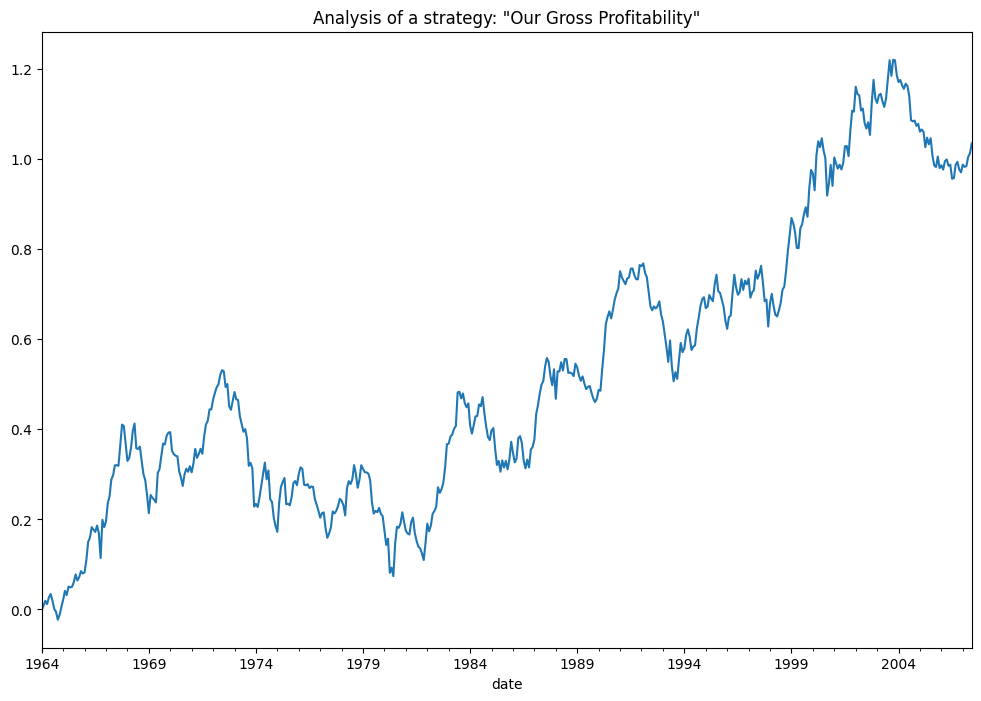

In [5]:
# start from the original data (we will modify it)
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

# construct the gross profitability variable
cs_crsp['gross_profitability'] = (cs_crsp['sale'] - cs_crsp['cogs']) / cs_crsp['at']
bad_data = cs_crsp['at'] <= 0 
cs_crsp.loc[bad_data, 'gross_profitability'] = np.nan

sort_variables = ['me', 'gross_profitability']
percentiles = {'me': [50],
              'gross_profitability': [30, 70]}

for sortvar in sort_variables:
    cs_crsp = portfolio_sort(df=cs_crsp, col=sortvar, percentiles=percentiles[sortvar], id_col=sortvar + '_group', annual=True)
    
sort_groups = [sortvar + '_group' for sortvar in sort_variables]

portfolio_returns = compute_portfolio_returns(cs_crsp, sort_groups=sort_groups)

gp = portfolio_returns.loc[:,[(1,3), (2,3)]].mean(axis=1) - portfolio_returns.loc[:,[(1,1), (2,1)]].mean(axis=1)
gp.name = 'gp'

analyze_returns(gp, 'Our Gross Profitability', end_date='2007-06')

### b) What is this factor's annualized alpha in the three-factor model over the full sample?

In [6]:
regression_data = pd.concat([gp, ff_data], axis=1).dropna()

y = regression_data['gp']
X = regression_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Create a model. This is an OBJECT that comes with methods. We are NOT estimating the model yet, just creating it.
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
display(results.summary())

print(f"\nThe factor's annualized alpha is {12 * results.params['const']:.2%}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     gp   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     74.14
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           9.72e-42
Time:                        19:13:28   Log-Likelihood:                 1704.7
No. Observations:                 716   AIC:                            -3401.
Df Residuals:                     712   BIC:                            -3383.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.563      0.000       0.002       0.006
Mkt-RF        -0.0061      0.020     -0.305      0.761      -0.045       0.033
SMB           -0.0067      0.029     -0.232      0.817      -0.064       0.050
HML           -0.4231      0.029    -14.638      0.000      -0.480      -0.366
==============================================================================
Omnibus:                       24.963   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.963
Skew:                           0.192   Prob(JB):                     1.41e-11
Kurtosis:                       4.236   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


The factor's annualized alpha is 4.67%
